In this notebook we will:
1. Evaluate bias in the current model  
2. Compute fairness metrics  
3. Identify problematic features  
4. Mitigate bias (e.g. drop or transform features)  
5. Re-train the model  
6. Compare “before vs after” on both performance and fairness  


In [1]:
import sys
from pathlib import Path

project_root = Path().cwd().parent
sys.path.append(str(project_root))

from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import sys
import os
import importlib
import pathlib

# Add project to path so we can import our modules
sys.path.append(os.path.abspath(".."))

# Import functionality from our source code
import src.data_loading.data_loader as data_loader
importlib.reload(data_loader)
from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features

# Loading intermediate dataset
script_dir  = pathlib.Path.cwd()              
project_root = script_dir.parent

save_dir = project_root / 'data' / 'processed'

file_path_25k_rows = project_root / 'data' / 'processed' / 'initial_processed_dataset_25k_rows.csv'
file_path_10k_rows = project_root / 'data' / 'processed' / 'initial_processed_dataset_10k_rows.csv'

df_full=load_data(str(project_root/'data'/'raw'/'credit_score_dataset.csv'))
df_25k_rows = load_data(str(file_path_25k_rows))
df_10k_rows = load_data(str(file_path_10k_rows))
df=df_10k_rows

Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\raw\credit_score_dataset.csv
Loaded dataset with 100000 rows and 27 columns
Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\processed\initial_processed_dataset_25k_rows.csv
Loaded dataset with 25000 rows and 32 columns
Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\processed\initial_processed_dataset_10k_rows.csv
Loaded dataset with 10000 rows and 32 columns


In [3]:
X = df.drop("Credit_Score", axis=1)
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

Train set: 8000 rows, Test set: 2000 rows


## 1- Build & Train Baseline Pipeline

We’ll assemble a minimal `ColumnTransformer` + `RandomForestClassifier`.


In [4]:
num_feats = get_numerical_features(X_train)
cat_feats = get_categorical_features(X_train)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # fill numeric NaNs
    ("scaler",  StandardScaler()),                   # then scale
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  
      # fill categorical NaNs with mode
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),  
      # then one-hot encode
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_feats),
    ("cat", cat_pipeline, cat_feats),
])

baseline_pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

baseline_pipe.fit(X_train, y_train)
print("Baseline pipeline trained (with imputation).")


Baseline pipeline trained (with imputation).


## 2- Baseline Evaluation

Compute standard metrics 


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.98      0.97      0.97       590
           2       0.97      0.98      0.98      1054
           3       0.97      0.95      0.96       348

    accuracy                           0.97      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.97      0.97      0.97      2000

MAE: 0.0315


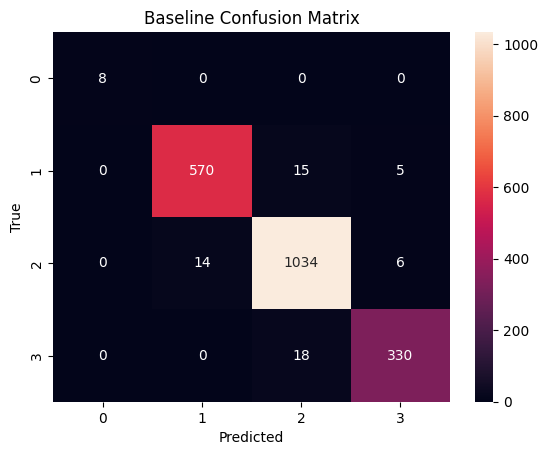

In [5]:
y_pred_base = baseline_pipe.predict(X_test)

print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))
print("MAE:",mean_absolute_error(y_test, y_pred_base))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 3- Identify Biased Feature

Check if predictions differ across the sensitive feature **City**.


Predicted distribution by City:


col_0,0,1,2,3
City,,,,
BadShire,0.0,1.000000,0.00000,0.000000
Lonton,0.0,0.000000,0.00000,1.000000
Standhampton,0.0,0.000000,1.00000,0.000000
Unknown,0.0,0.254717,0.59434,0.150943
ZeroVille,1.0,0.000000,0.00000,0.000000


C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Almi\AppDa

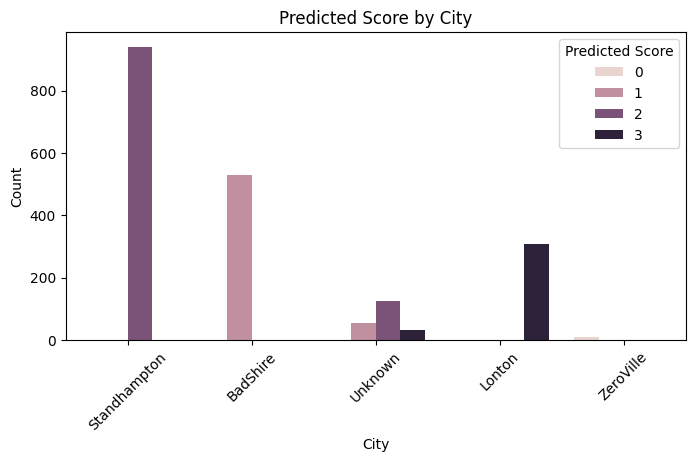

In [6]:
print("Predicted distribution by City:")
display(pd.crosstab(X_test["City"], y_pred_base, normalize="index"))

# Visualize with countplot
plt.figure(figsize=(8,4))
sns.countplot(x="City", hue=y_pred_base, data=X_test.assign(pred=y_pred_base))
plt.title("Predicted Score by City")
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Count")
plt.legend(title="Predicted Score")
plt.show()


## 4- Mitigation: Drop “City”

We’ll remove **City** from features, rebuild & re-train.


In [7]:
X_train_nb = X_train.drop("City", axis=1)
X_test_nb  = X_test.drop("City", axis=1)

# Recompute feature lists without City
num_feats_nb = get_numerical_features(X_train_nb)
cat_feats_nb = get_categorical_features(X_train_nb)

# Rebuild imputation + transformation pipelines
num_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
cat_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_nb = ColumnTransformer([
    ("num", num_pipeline_nb, num_feats_nb),
    ("cat", cat_pipeline_nb, cat_feats_nb),
])

# Assemble mitigated pipeline
mitigated_pipe = Pipeline([
    ("preproc", preprocessor_nb),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

# Fit mitigated pipeline
mitigated_pipe.fit(X_train_nb, y_train)
print("Mitigated pipeline (no City) trained.")

Mitigated pipeline (no City) trained.


## 5- Post-Mitigation Evaluation

Compare performance & fairness “before vs after”.


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.98      0.97      0.97       590
           2       0.97      0.98      0.98      1054
           3       0.97      0.95      0.96       348

    accuracy                           0.97      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.97      0.97      0.97      2000

MAE: 0.0315
=== AFTER DROPPING CITY ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.79      0.79      0.79       590
           2       0.80      0.82      0.81      1054
           3       0.78      0.74      0.76       348

    accuracy                           0.79      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.79      0.79      0.79      2000

MAE: 0.2135


C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

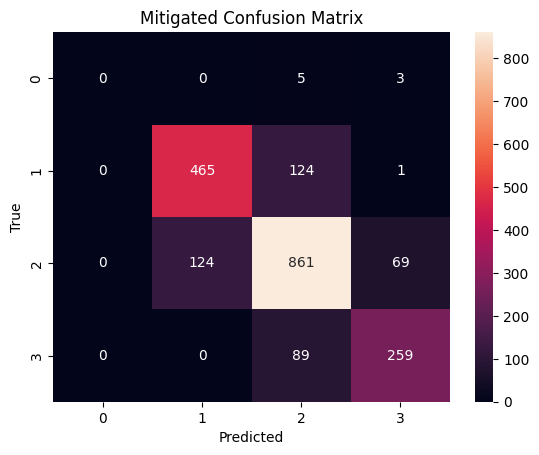

In [8]:
# Cell 11: Predictions after mitigation
y_pred_nb = mitigated_pipe.predict(X_test_nb)

print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))
print("MAE:",mean_absolute_error(y_test, y_pred_base))
print("=== AFTER DROPPING CITY ===")
print(classification_report(y_test, y_pred_nb))
print("MAE:",mean_absolute_error(y_test, y_pred_nb))

# Visualize confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d")
plt.title("Mitigated Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6- Summary Comparison

Tabulate & plot accuracy before vs after mitigation.


,Metric,Baseline,No_City
0,Accuracy,0.9710,0.7925
1,F1_macro,0.9760,0.5895
2,MAE,0.0315,0.2135


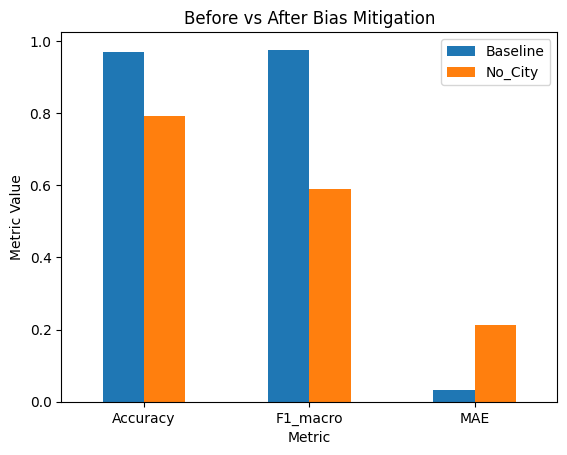

In [9]:
from sklearn.metrics import accuracy_score, f1_score

# baseline
acc_base = accuracy_score(y_test, y_pred_base)
f1_base  = f1_score     (y_test, y_pred_base, average='macro')
mae_base = mean_absolute_error(y_test,y_pred_base)

# no-city
acc_nb   = accuracy_score(y_test, y_pred_nb)
f1_nb    = f1_score     (y_test, y_pred_nb, average='macro')
mae_nb = mean_absolute_error(y_test,y_pred_nb)

metrics_summary = pd.DataFrame({
    "Metric":    ["Accuracy", "F1_macro", "MAE"],
    "Baseline":  [np.round(acc_base, 4), np.round(f1_base, 4), np.round(mae_base,4)],
    "No_City":   [np.round(acc_nb,   4), np.round(f1_nb,   4), np.round(mae_nb,4)]
})
display(metrics_summary)

ax = metrics_summary.set_index("Metric")[["Baseline","No_City"]].plot.bar(rot=0)
ax.set_title("Before vs After Bias Mitigation")
ax.set_ylabel("Metric Value")
plt.show()

## Explainability

Analyzing 200 samples...
Calculating SHAP values...


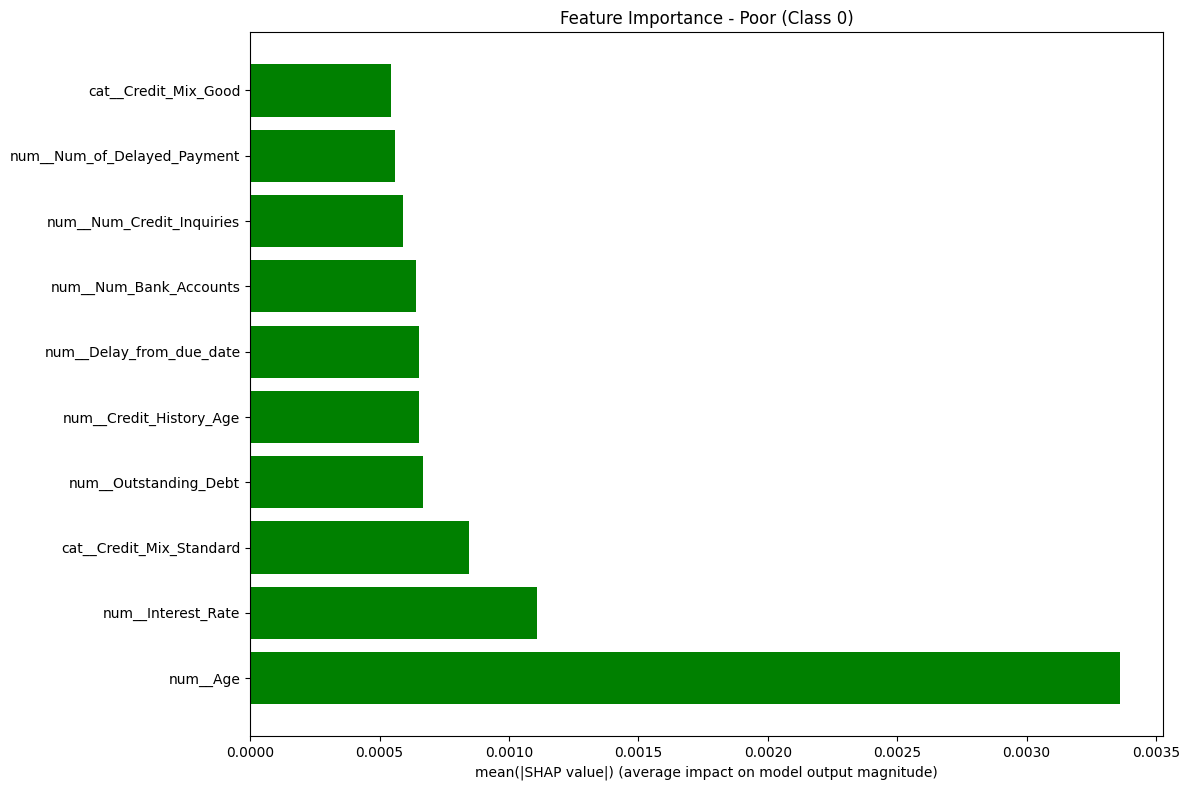

Top 5 important features for Poor class:
  1. num__Age: 0.0034
  2. num__Interest_Rate: 0.0011
  3. cat__Credit_Mix_Standard: 0.0008
  4. num__Outstanding_Debt: 0.0007
  5. num__Credit_History_Age: 0.0007


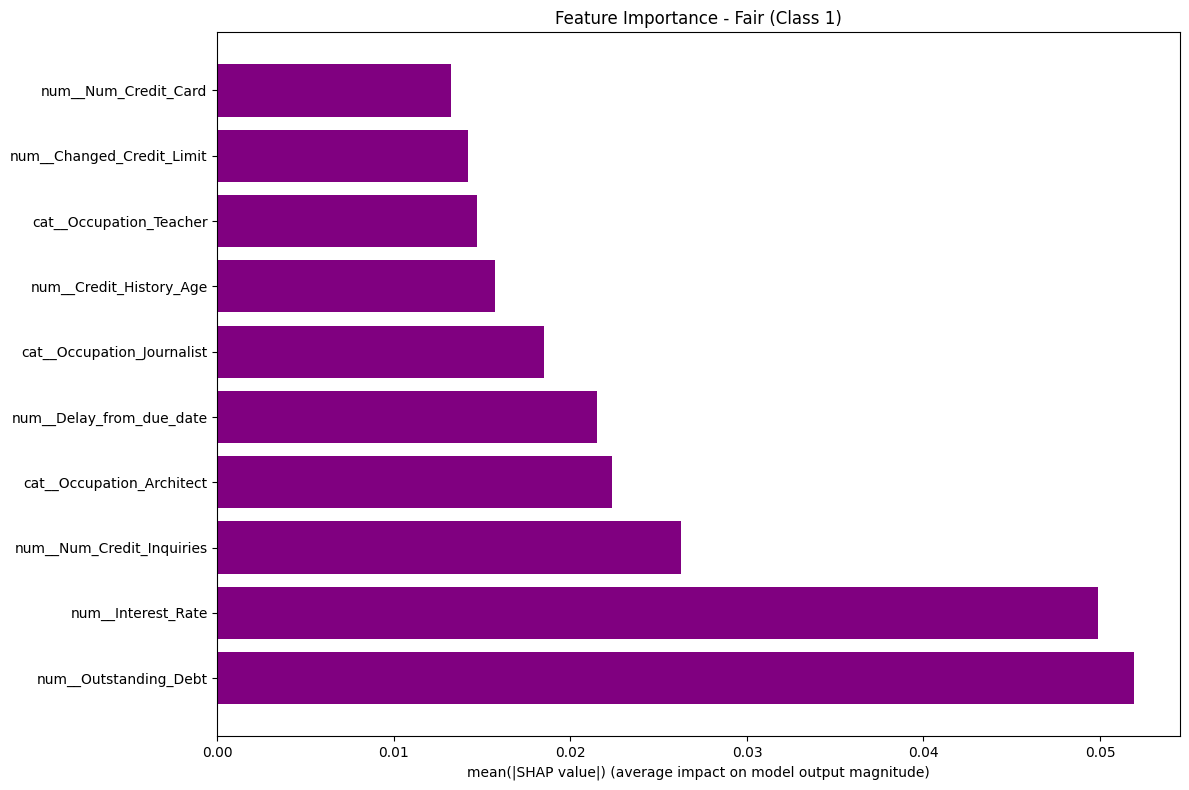

Top 5 important features for Fair class:
  1. num__Outstanding_Debt: 0.0519
  2. num__Interest_Rate: 0.0499
  3. num__Num_Credit_Inquiries: 0.0263
  4. cat__Occupation_Architect: 0.0224
  5. num__Delay_from_due_date: 0.0215


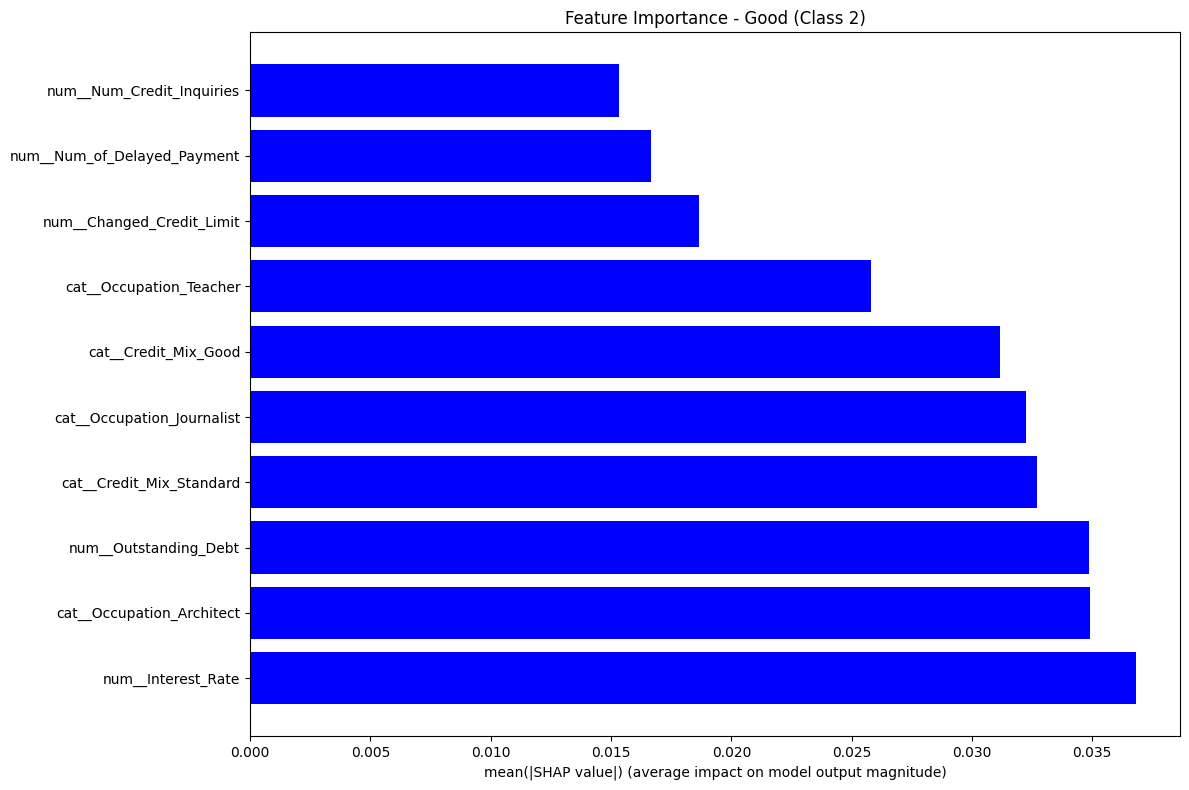

Top 5 important features for Good class:
  1. num__Interest_Rate: 0.0368
  2. cat__Occupation_Architect: 0.0349
  3. num__Outstanding_Debt: 0.0349
  4. cat__Credit_Mix_Standard: 0.0327
  5. cat__Occupation_Journalist: 0.0322


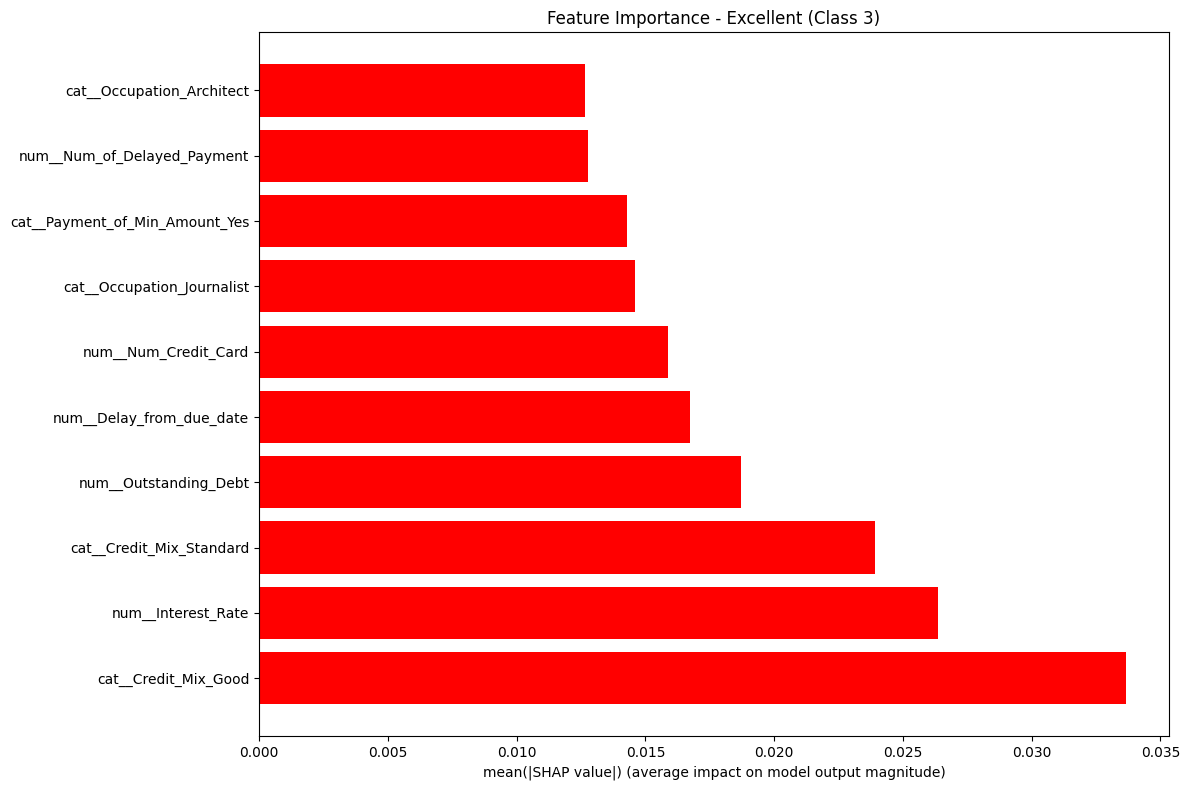

Top 5 important features for Excellent class:
  1. cat__Credit_Mix_Good: 0.0336
  2. num__Interest_Rate: 0.0263
  3. cat__Credit_Mix_Standard: 0.0239
  4. num__Outstanding_Debt: 0.0187
  5. num__Delay_from_due_date: 0.0167


In [ ]:
import shap
import time
import matplotlib

matplotlib.use('module://matplotlib_inline.backend_inline')

def fast_tree_shap_analysis(model_pipe, X, sample_size=50):
    """Get SHAP values for tree model"""
    print(f"Analyzing {min(sample_size, len(X))} samples...")
    
    # Sample the data
    X_sample = X.sample(n=min(sample_size, len(X)), random_state=42) 
    
    # Get components from pipeline
    preprocessor = model_pipe.named_steps['preproc']
    model = model_pipe.named_steps['clf']
    
    # Transform features
    X_transformed = preprocessor.transform(X_sample)
    if hasattr(X_transformed, 'toarray'):
        X_transformed = X_transformed.toarray()
    
    # Get feature names
    try:
        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out()
        else:
            feature_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
    except:
        feature_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
    
    # Create dataframe from transformed features
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
    
    # Create explainer and get SHAP values
    print("Calculating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_transformed_df)
    
    return {
        'explainer': explainer,
        'shap_values': shap_values,
        'X_transformed': X_transformed_df,
        'feature_names': feature_names
    }

def plot_class_specific_shap(shap_results, class_idx):
    """Plot feature importance for a specific class using 3D SHAP values"""
    shap_values = shap_results['shap_values']
    feature_names = shap_results['feature_names']
    class_names = ["Zero", "Poor", "Standard", "Good"]
    
    # Extract SHAP values for the specific class
    # Shape is (n_samples, n_features, n_classes)
    if shap_values.shape[2] > class_idx:
        # Extract values for this class: all samples, all features, specific class
        class_values = shap_values[:, :, class_idx]
        
        # Calculate feature importance (mean absolute SHAP value per feature)
        feature_importance = np.mean(np.abs(class_values), axis=0)
        
        # Get top 10 features
        idx = np.argsort(feature_importance)[-10:][::-1]
        top_features = [feature_names[i] for i in idx]
        top_importances = feature_importance[idx]
        
        # Plot
        plt.figure(figsize=(12, 8))
        colors = ['green', 'purple', 'blue', 'red']  # Match the colors in your original plot
        plt.barh(range(len(idx)), top_importances, color=colors[class_idx])
        plt.yticks(range(len(idx)), top_features)
        plt.title(f"Feature Importance - {class_names[class_idx]} (Class {class_idx})")
        plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
        plt.tight_layout()
        plt.show()
        
        print(f"Top 5 important features for {class_names[class_idx]} class:")
        for i in range(min(5, len(idx))):
            print(f"  {i+1}. {top_features[i]}: {top_importances[i]:.4f}")
    

# First get the SHAP results
shap_results = fast_tree_shap_analysis(mitigated_pipe, X_test, sample_size=200)

# Then plot each class individually
#for class_idx in range(4):  # 0, 1, 2, 3
#    print(f"Plotting Class {class_idx} - {['Poor', 'Fair', 'Good', 'Excellent'][class_idx]}")
#    plot_tree_shap_results(shap_results, class_idx=class_idx)

#plot_tree_shap_results(shap_results, class_idx=0)

# Plot each class separately with non-stacked bars
for class_idx in range(4):
    plot_class_specific_shap(shap_results, class_idx)